In [90]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

from MieSppForce.simulation import SimulationConfig, SweepRunner, DipoleCalculator, OpticalForceCalculator
import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()

base_config = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2 
)

In [2]:
from MieSppForce.green_func_v2 import clear_cache

clear_cache()

In [91]:
from MieSppForce.simulation import SphericalGrid, CylindricalGrid

r_multiplier = 3


gridXoZ = SphericalGrid(
    r=r_multiplier*base_config.wl,
    theta=np.linspace(-np.pi/2, np.pi/2, 100)*ureg.rad,
    phi=0* ureg.radian
)

gridYoZ =  SphericalGrid(
    r=r_multiplier*base_config.wl,
    theta=np.linspace(-np.pi/2, np.pi/2, 100)*ureg.rad,
    phi=np.pi/2* ureg.radian
)

gridXoY = CylindricalGrid(
    r = r_multiplier*base_config.wl,
    phi = np.linspace(0,2*np.pi,100) * ureg.rad,
    z=0 * ureg.nm
)



In [92]:
from MieSppForce.simulation import FieldsCalculator, DiagramCalculator, DipoleCalculator

setattr(base_config, 'wl', 800 * ureg.nanometer)

XoY_diag_spp = DiagramCalculator(base_config, gridXoY).compute(field_type='spp')

XoZ_diag_air = DiagramCalculator(base_config, gridXoZ).compute(field_type='air')

YoZ_diag_air = DiagramCalculator(base_config, gridYoZ).compute(field_type='air')

XoZ_diag_sc = DiagramCalculator(base_config, gridXoZ).compute(field_type='sc')

YoZ_diag_sc = DiagramCalculator(base_config, gridYoZ).compute(field_type='sc')

XoZ_diag_reg = DiagramCalculator(base_config, gridXoZ).compute(field_type='reg')

YoZ_diag_reg = DiagramCalculator(base_config, gridYoZ).compute(field_type='reg')


Dipoles_res = DipoleCalculator(base_config).compute()


# FieldXoY = FieldsCalculator(base_config).compute(gridXoY)
# FieldYoZ = FieldsCalculator(base_config).compute(gridYoZ)
# FieldXoZ = FieldsCalculator(base_config).compute(gridXoZ)

100%|██████████| 100/100 [00:00<00:00, 1671.32it/s]


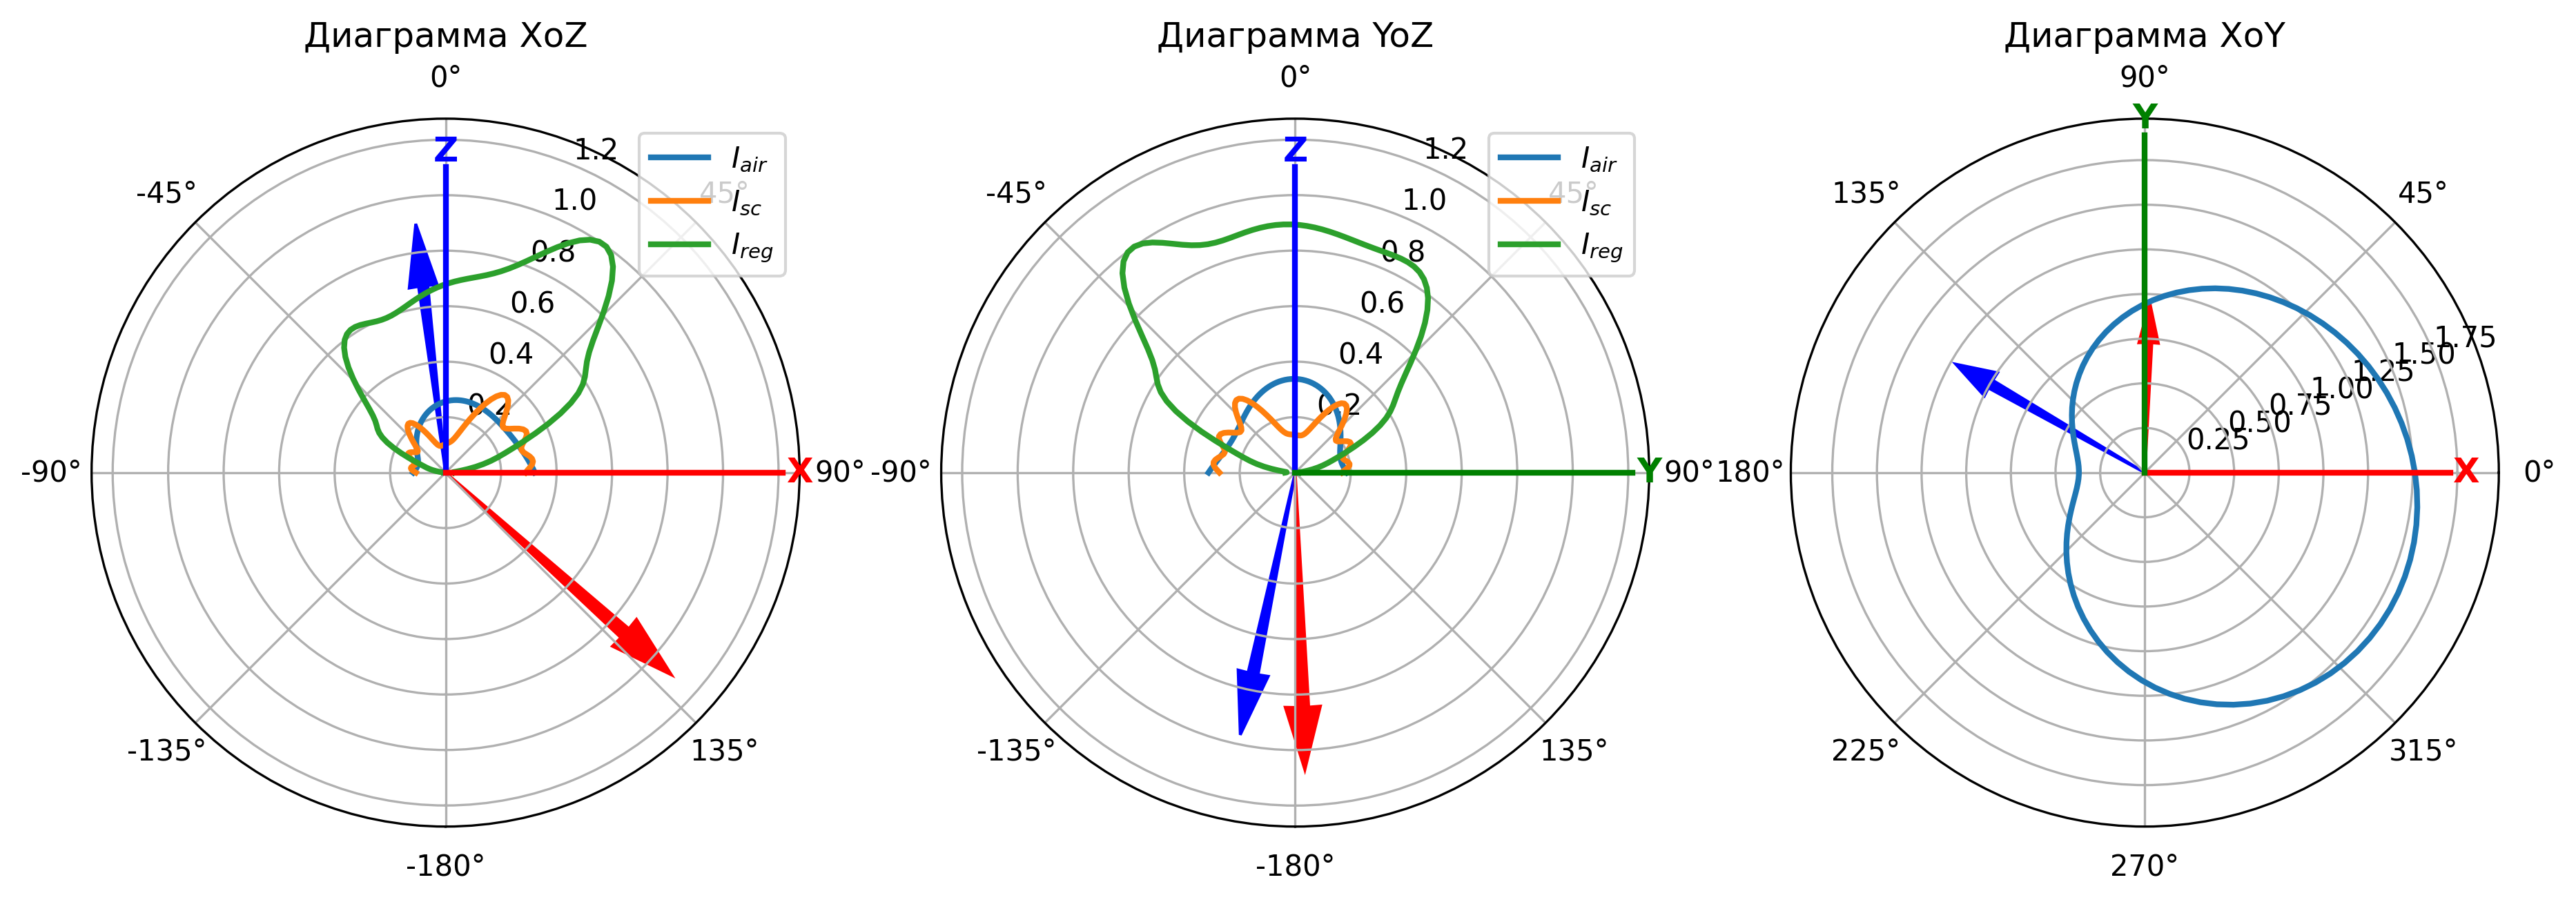

In [93]:
import numpy as np
import matplotlib.pyplot as plt


theta_YoZ_air, I_YoZ_air = YoZ_diag_air.as_array()[:,0], YoZ_diag_air.as_array()[:,1]
theta_XoZ_air, I_XoZ_air = XoZ_diag_air.as_array()[:,0], XoZ_diag_air.as_array()[:,1]

theta_XoY_spp, I_XoY_spp = XoY_diag_spp.as_array()[:,0], XoY_diag_spp.as_array()[:,1]

theta_YoZ_sc, I_YoZ_sc = YoZ_diag_sc.as_array()[:,0], YoZ_diag_sc.as_array()[:,1]
theta_XoZ_sc, I_XoZ_sc = XoZ_diag_sc.as_array()[:,0], XoZ_diag_sc.as_array()[:,1]

theta_YoZ_reg, I_YoZ_reg = YoZ_diag_reg.as_array()[:,0], YoZ_diag_reg.as_array()[:,1]
theta_XoZ_reg, I_XoZ_reg = XoZ_diag_reg.as_array()[:,0], XoZ_diag_reg.as_array()[:,1]



fig, ax = plt.subplots(
    1, 3, figsize=(15, 5), dpi=300,
    subplot_kw={'projection': 'polar'}
)

def add_axis_line(ax, theta, label, color="k"):
    """Добавляет стрелку оси и подпись в полярной системе"""
    r_arrow = ax.get_rmax() * 1.05
    ax.plot([theta, theta], [0, r_arrow], color=color, lw=2)
    ax.text(theta, r_arrow*1.05, label, ha='center', va='center', fontsize=12, fontweight='bold', color=color)

# --- XoZ ---
ax[0].set_theta_offset(np.pi/2)
ax[0].set_theta_direction(-1)
ax[0].set_thetalim(-np.pi, np.pi)
ax[0].plot(theta_XoZ_air, I_XoZ_air/np.max(I_XoZ_reg), lw=2, label='$I_{air}$')
ax[0].plot(theta_XoZ_sc, I_XoZ_sc/np.max(I_XoZ_reg), lw=2, label='$I_{sc}$')
ax[0].plot(theta_XoZ_reg, I_XoZ_reg/np.max(I_XoZ_reg), lw=2, label='$I_{reg}$')
ax[0].legend()
ax[0].set_title("Диаграмма XoZ")
add_axis_line(ax[0], 0, "Z", color="b")
add_axis_line(ax[0], np.pi/2, "X", color="r")

# --- YoZ ---
ax[1].set_theta_offset(np.pi/2)
ax[1].set_theta_direction(-1)
ax[1].set_thetalim(-np.pi, np.pi)
ax[1].plot(theta_YoZ_air, I_YoZ_air/np.max(I_YoZ_reg), lw=2, label='$I_{air}$')
ax[1].plot(theta_YoZ_sc, I_YoZ_sc/np.max(I_YoZ_reg), lw=2, label='$I_{sc}$')
ax[1].plot(theta_YoZ_reg, I_YoZ_reg/np.max(I_YoZ_reg), lw=2, label='$I_{reg}$')
ax[1].legend()
ax[1].set_title("Диаграмма YoZ")
add_axis_line(ax[1], 0, "Z", color="b")
add_axis_line(ax[1], np.pi/2, "Y", color="g")

# --- XoY ---
ax[2].set_theta_zero_location("E")
ax[2].set_theta_direction(1)
ax[2].plot(theta_XoY_spp, I_XoY_spp, lw=2)
ax[2].set_title("Диаграмма XoY")
add_axis_line(ax[2], 0, "X", color="r")
add_axis_line(ax[2], np.pi/2, "Y", color="g")


dips = Dipoles_res.as_dict()

px  = dips['px'].magnitude
py = dips['py'].magnitude
pz = dips['pz'].magnitude
mx = dips['mx'].magnitude
my = dips['my'].magnitude
mz = dips['mz'].magnitude

p_norm = np.sqrt(np.abs(px)**2 + np.abs(py)**2 + np.abs(pz)**2)
m_norm = np.sqrt(np.abs(mx)**2 + np.abs(my)**2 + np.abs(mz)**2)

ax[0].arrow(np.pi-np.atan2(pz.real, px.real), 0, 0, np.sqrt(np.abs(px)**2 + np.abs(pz)**2)/p_norm, color='b', width = 0.05, label='p')
ax[0].arrow(np.pi-np.atan2(mz.real, mx.real), 0, 0, np.sqrt(np.abs(mx)**2 + np.abs(mz)**2)/m_norm, color='r', width = 0.05, label='m')

ax[1].arrow(np.pi-np.atan2(pz.real, py.real), 0, 0, np.sqrt(np.abs(py)**2 + np.abs(pz)**2)/p_norm, color='b', width = 0.05, label='p')
ax[1].arrow(np.pi-np.atan2(mz.real, my.real), 0, 0, np.sqrt(np.abs(my)**2 + np.abs(mz)**2)/m_norm, color='r', width = 0.05, label='m')

ax[2].arrow(np.atan2(py.real, px.real), 0, 0, np.sqrt(np.abs(px)**2 + np.abs(py)**2)/p_norm, color='b', width = 0.05, label='p')
ax[2].arrow(np.atan2(my.real, mx.real), 0, 0, np.sqrt(np.abs(my)**2 + np.abs(mx)**2)/m_norm, color='r', width = 0.05, label='m')

plt.show()

In [16]:
sweep_res, diagrams, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 50)*ureg.nanometer, True, True, True, False, None, 'spp').run()

Sweeping 'wl': 100%|██████████| 50/50 [00:09<00:00,  5.12step/s]


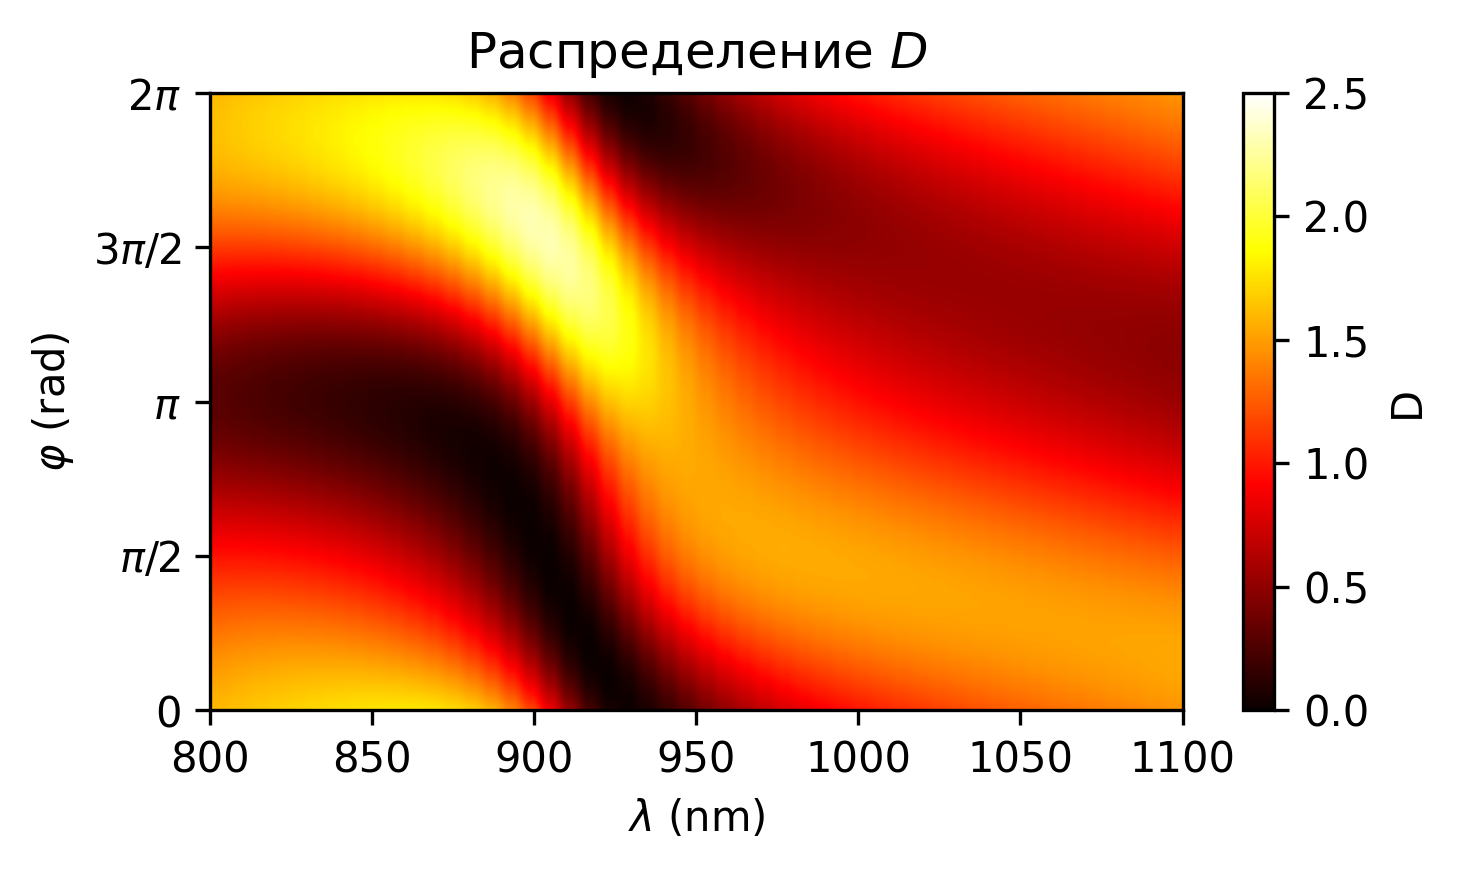

In [17]:
import numpy as np
import matplotlib.pyplot as plt

diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot = diagrams.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot.columns.min()), float(pivot.columns.max()),
        float(pivot.index.min()),   float(pivot.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('field/D_map.png', dpi=300)
plt.show()

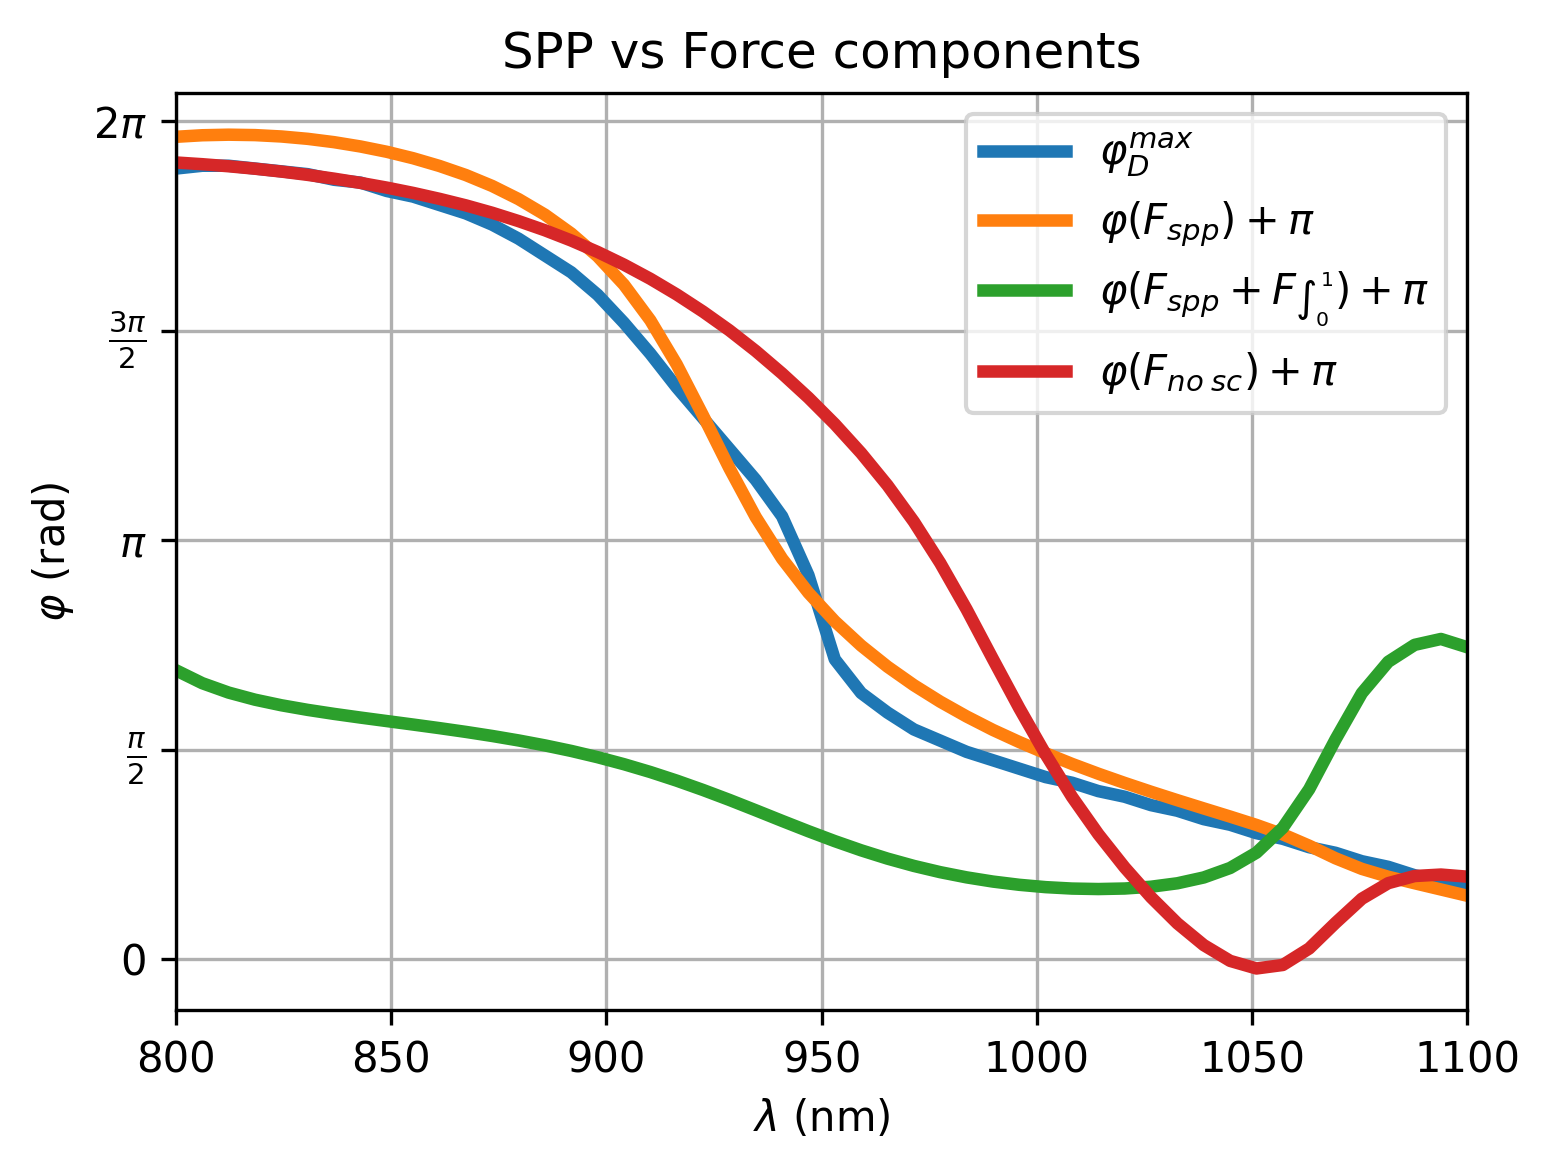

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. phi_max из диаграмм ---
diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

phi_max = (
    diagrams.loc[diagrams.groupby("wl")["D"].idxmax()][["wl", "phi"]]
    .rename(columns={"phi": "phi_max"})
)

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fy = sweep_res["Fy"].apply(lambda x: x.to("N").magnitude).to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fxm0 = sweep_res["Fxm0"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fxcross = sweep_res["Fxcross"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fycross = sweep_res["Fycross"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross

Fxspp = sweep_res["Fxspp"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fyspp = sweep_res["Fyspp"].apply(lambda x: x.to("N").magnitude).to_numpy()


Fx_01 = Fx - Fxe0 - Fxm0 - Fxcross - Fxspp
Fy_01 = Fy - Fycross - Fyspp


theta_F = np.arctan2(Fy, Fx)

theta_F_nosc = np.arctan2(Fy, Fx_nosc)

theta_F_nosc_noncross = np.arctan2(Fy_nosc_noncross, Fx_nosc_noncross)

theta_F_spp = np.arctan2(Fyspp, Fxspp)

theta_F_cross = np.arctan2(Fycross, Fxcross)


df_forces = pd.DataFrame({"wl": wl, "theta_F_spp": theta_F_spp, "theta_F_no_sc_no_cross": theta_F_nosc_noncross, "theta_F_nosc": theta_F_nosc, "theta_F_cross": theta_F_cross})

# --- 3. Совмещение ---
df_plot = pd.merge(phi_max, df_forces, on="wl")


# --- 4. Построение ---
plt.figure(figsize=(5,4), dpi=300)
plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", lw=3)
plt.plot(df_plot["wl"], df_plot["theta_F_spp"]+np.pi, label="$\\varphi(F_{spp})+\pi$", lw=3)
plt.plot(df_plot["wl"], df_plot["theta_F_no_sc_no_cross"]+np.pi, label="$\\varphi(F_{spp}+F_{\int_0^1})+\pi$", lw=3)
plt.plot(df_plot["wl"], np.unwrap(df_plot["theta_F_nosc"])+np.pi, label="$\\varphi(F_{no\;sc})+\pi$", lw=3)
# plt.plot(df_plot["wl"], df_plot["theta_F_cross"]+np.pi, label="$\\varphi(F_{cross})+\pi$", lw=3)



plt.xlabel("$\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("SPP vs Force components")
plt.legend()
plt.grid(True)
plt.tight_layout()

yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
ytick_labels = ["0", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]

plt.yticks(yticks, ytick_labels)
plt.xlim(df_plot["wl"].to_numpy()[0],df_plot["wl"].to_numpy()[-1])
#plt.savefig('field/SPP_F_angles.png', dpi=300)
plt.show()

In [22]:
#Free Space

base_config_free_space = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(0),
    a_angle = 0,
    phase= 0,
    substrate='Air',
    amplitude=100*1e-3*2/(299792458 *1/(4*np.pi*299792458**2)*1e7)
)

sweep_res_free_space, _, _ = SweepRunner(base_config_free_space, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, False, True, False).run()



Sweeping 'wl': 100%|██████████| 100/100 [00:01<00:00, 70.63step/s]


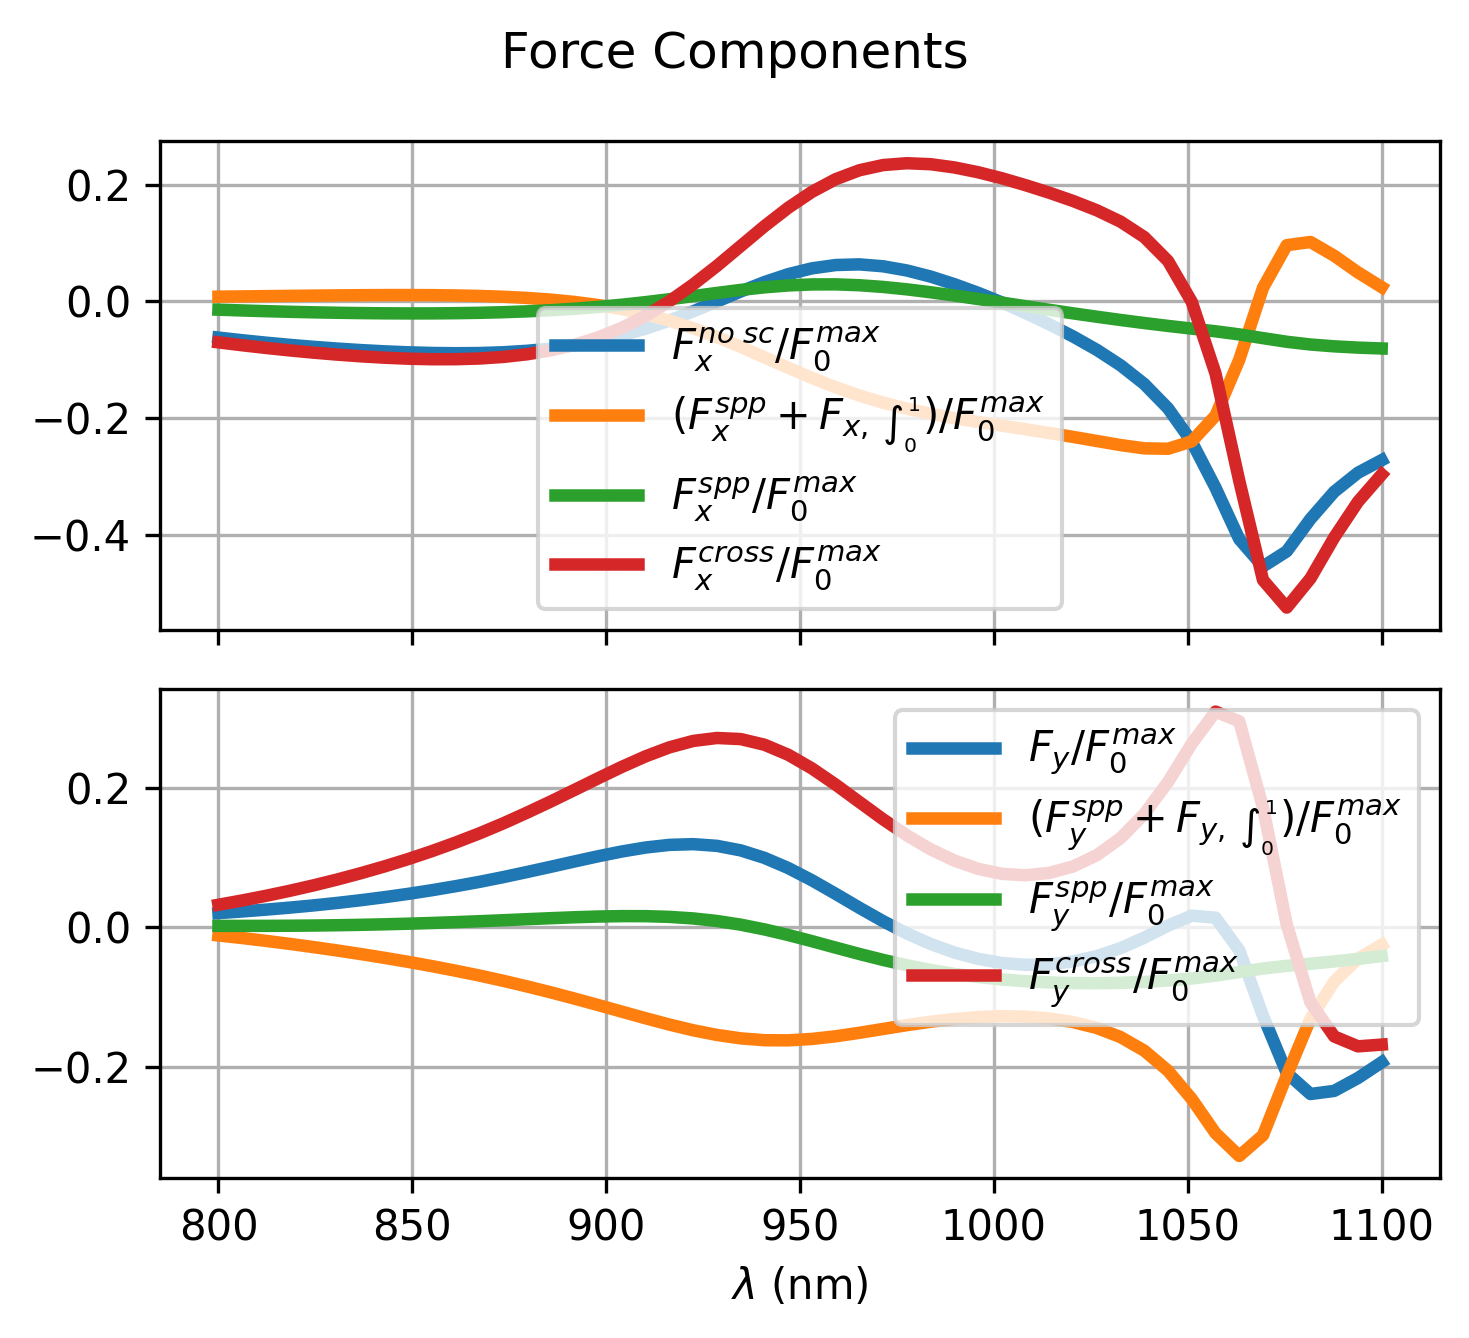

In [32]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])
Fxcross_norm   =  np.array([f / F0 for f in Fxcross])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])
Fycross_norm   =  np.array([f / F0 for f in Fycross])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
# axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\;sc}/F_0^{max}$", lw=3)
axs[0].plot(wl, Fxnocross_norm, label="$(F_x^{spp}+F_{x,\;\int_0^1} )/ F_0^{max}$", lw=3)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{spp} / F_0^{max}$", lw=3)
axs[0].plot(wl, Fxcross_norm, label="$F_x^{cross} / F_0^{max}$", lw=3)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
axs[1].plot(wl, Fynocross_norm, label="$(F_y^{spp}+F_{y,\;\int_0^1})/ F_0^{max}$", lw=3)
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm, label="$F_y^{cross} / F_0^{max}$", lw=3)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Force Components")
plt.tight_layout()
#plt.savefig('field/SPP_Force_Components.png', dpi=300)
plt.show()

In [ ]:
from MieSppForce import green_func_v2, frenel, green_func

from tqdm import tqdm
wl=800
# epsConst = -24.061488741942565+1.5068228110835038*1j
epsAu = frenel.get_interpolate('Au')
z0=20
z=10
h = z + z0
rs = np.linspace(2000,3000,100)
phi = np.pi/4

GE = np.zeros((len(rs),3,3), dtype=complex)

for i,r in tqdm(enumerate(rs)):
    GEi, rotGHi, GHi, rotGEi = green_func_v2.getG(wl, epsAu, h, r, phi)
    GE[i,:,:] = rotGEi


In [ ]:
# --- построение графиков ---
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for row in range(3):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(rs, GE[:, row, col].real, 'b-', label='Re')
        ax.plot(rs, GE[:, row, col].imag, 'r--', label='Im')
        ax.set_xlabel("r")
        ax.set_ylabel(f"G{row+1}{col+1}")
        ax.set_title(f"Компонента G{row+1}{col+1}, φ={phi:.2f} рад")
        ax.grid(True)
        ax.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
        if row == 0 and col == 0:
            ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
px= sweep_res['px'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
py = sweep_res['py'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
pz = sweep_res['pz'].apply(lambda x: x.to('C*m').magnitude).to_numpy()

mx = sweep_res['mx'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
my = sweep_res['my'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
mz = sweep_res['mz'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()


wls = sweep_res['wl'].apply(lambda x: x.to('nm').magnitude).to_numpy()

In [ ]:
p_coms = np.loadtxt('p_tm.txt', skiprows=8, delimiter=',')
m_coms = np.loadtxt('m_tm.txt', skiprows=8, delimiter=',')

In [ ]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, my.real/base_config.c_const, label='python re my', c='r')
#plt.plot(m_coms[:,0], m_coms[:,3]/base_config.c_const, c='r', ls='--', label='comsol re my')

plt.plot(wls, my.imag/base_config.c_const, c='b', label='python im my')
#plt.plot(m_coms[:,0], -m_coms[:,4]/base_config.c_const, c='b', ls='--', label='comsol im my')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

In [ ]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, pz.real, label='re pz python', c='r')
#plt.plot(p_coms[:,0], p_coms[:,5], c='r', ls='--', label='re pz comsol')

plt.plot(wls, pz.imag, c='b', label='im pz python')
#plt.plot(p_coms[:,0], -p_coms[:,6], c='b', ls='--', label='im pz comsol')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

In [ ]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, px.real, label='re px python', c='r')
#plt.plot(p_coms[:,0], p_coms[:,1], c='r', ls='--', label='re px comsol')

plt.plot(wls, px.imag, c='b', label='im px python')
#plt.plot(p_coms[:,0], -p_coms[:,2], c='b', ls='--', label='im px comsol')
plt.xlim(800,1100)
plt.grid()
plt.legend()
plt.xlabel('lambda, nm')
plt.ylabel('p, C*m')

In [ ]:
dips

In [18]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

grid = CylindricalGrid(
    r=np.linspace(0,2000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

gridFF = CylindricalGrid(
    r=20*base_config.wl,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

In [10]:
FarField = FieldsCalculator(base_config).compute(gridFF)

100%|██████████| 200/200 [00:01<00:00, 165.29it/s]


In [34]:
base_config_900 = SimulationConfig(
    wl = 902 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2,
)

In [35]:
FiledAir = FieldsCalculator(base_config_900).compute(grid, 'air')
FiledFull = FieldsCalculator(base_config_900).compute(grid)
dips900 = DipoleCalculator(base_config_900).compute()

100%|██████████| 20000/20000 [00:11<00:00, 1684.83it/s]


In [21]:
dips900

px: 6.951e-48 + -3.829e-47j [C * m]
py: 8.944e-31 + 1.503e-31j [C * m]
pz: 1.275e-47 + 9.958e-49j [C * m]
mx: 1.573e-23 + -3.723e-23j [A * m ** 2]
my: 1.204e-39 + -1.156e-39j [A * m ** 2]
mz: 5.667e-24 + 6.678e-23j [A * m ** 2]

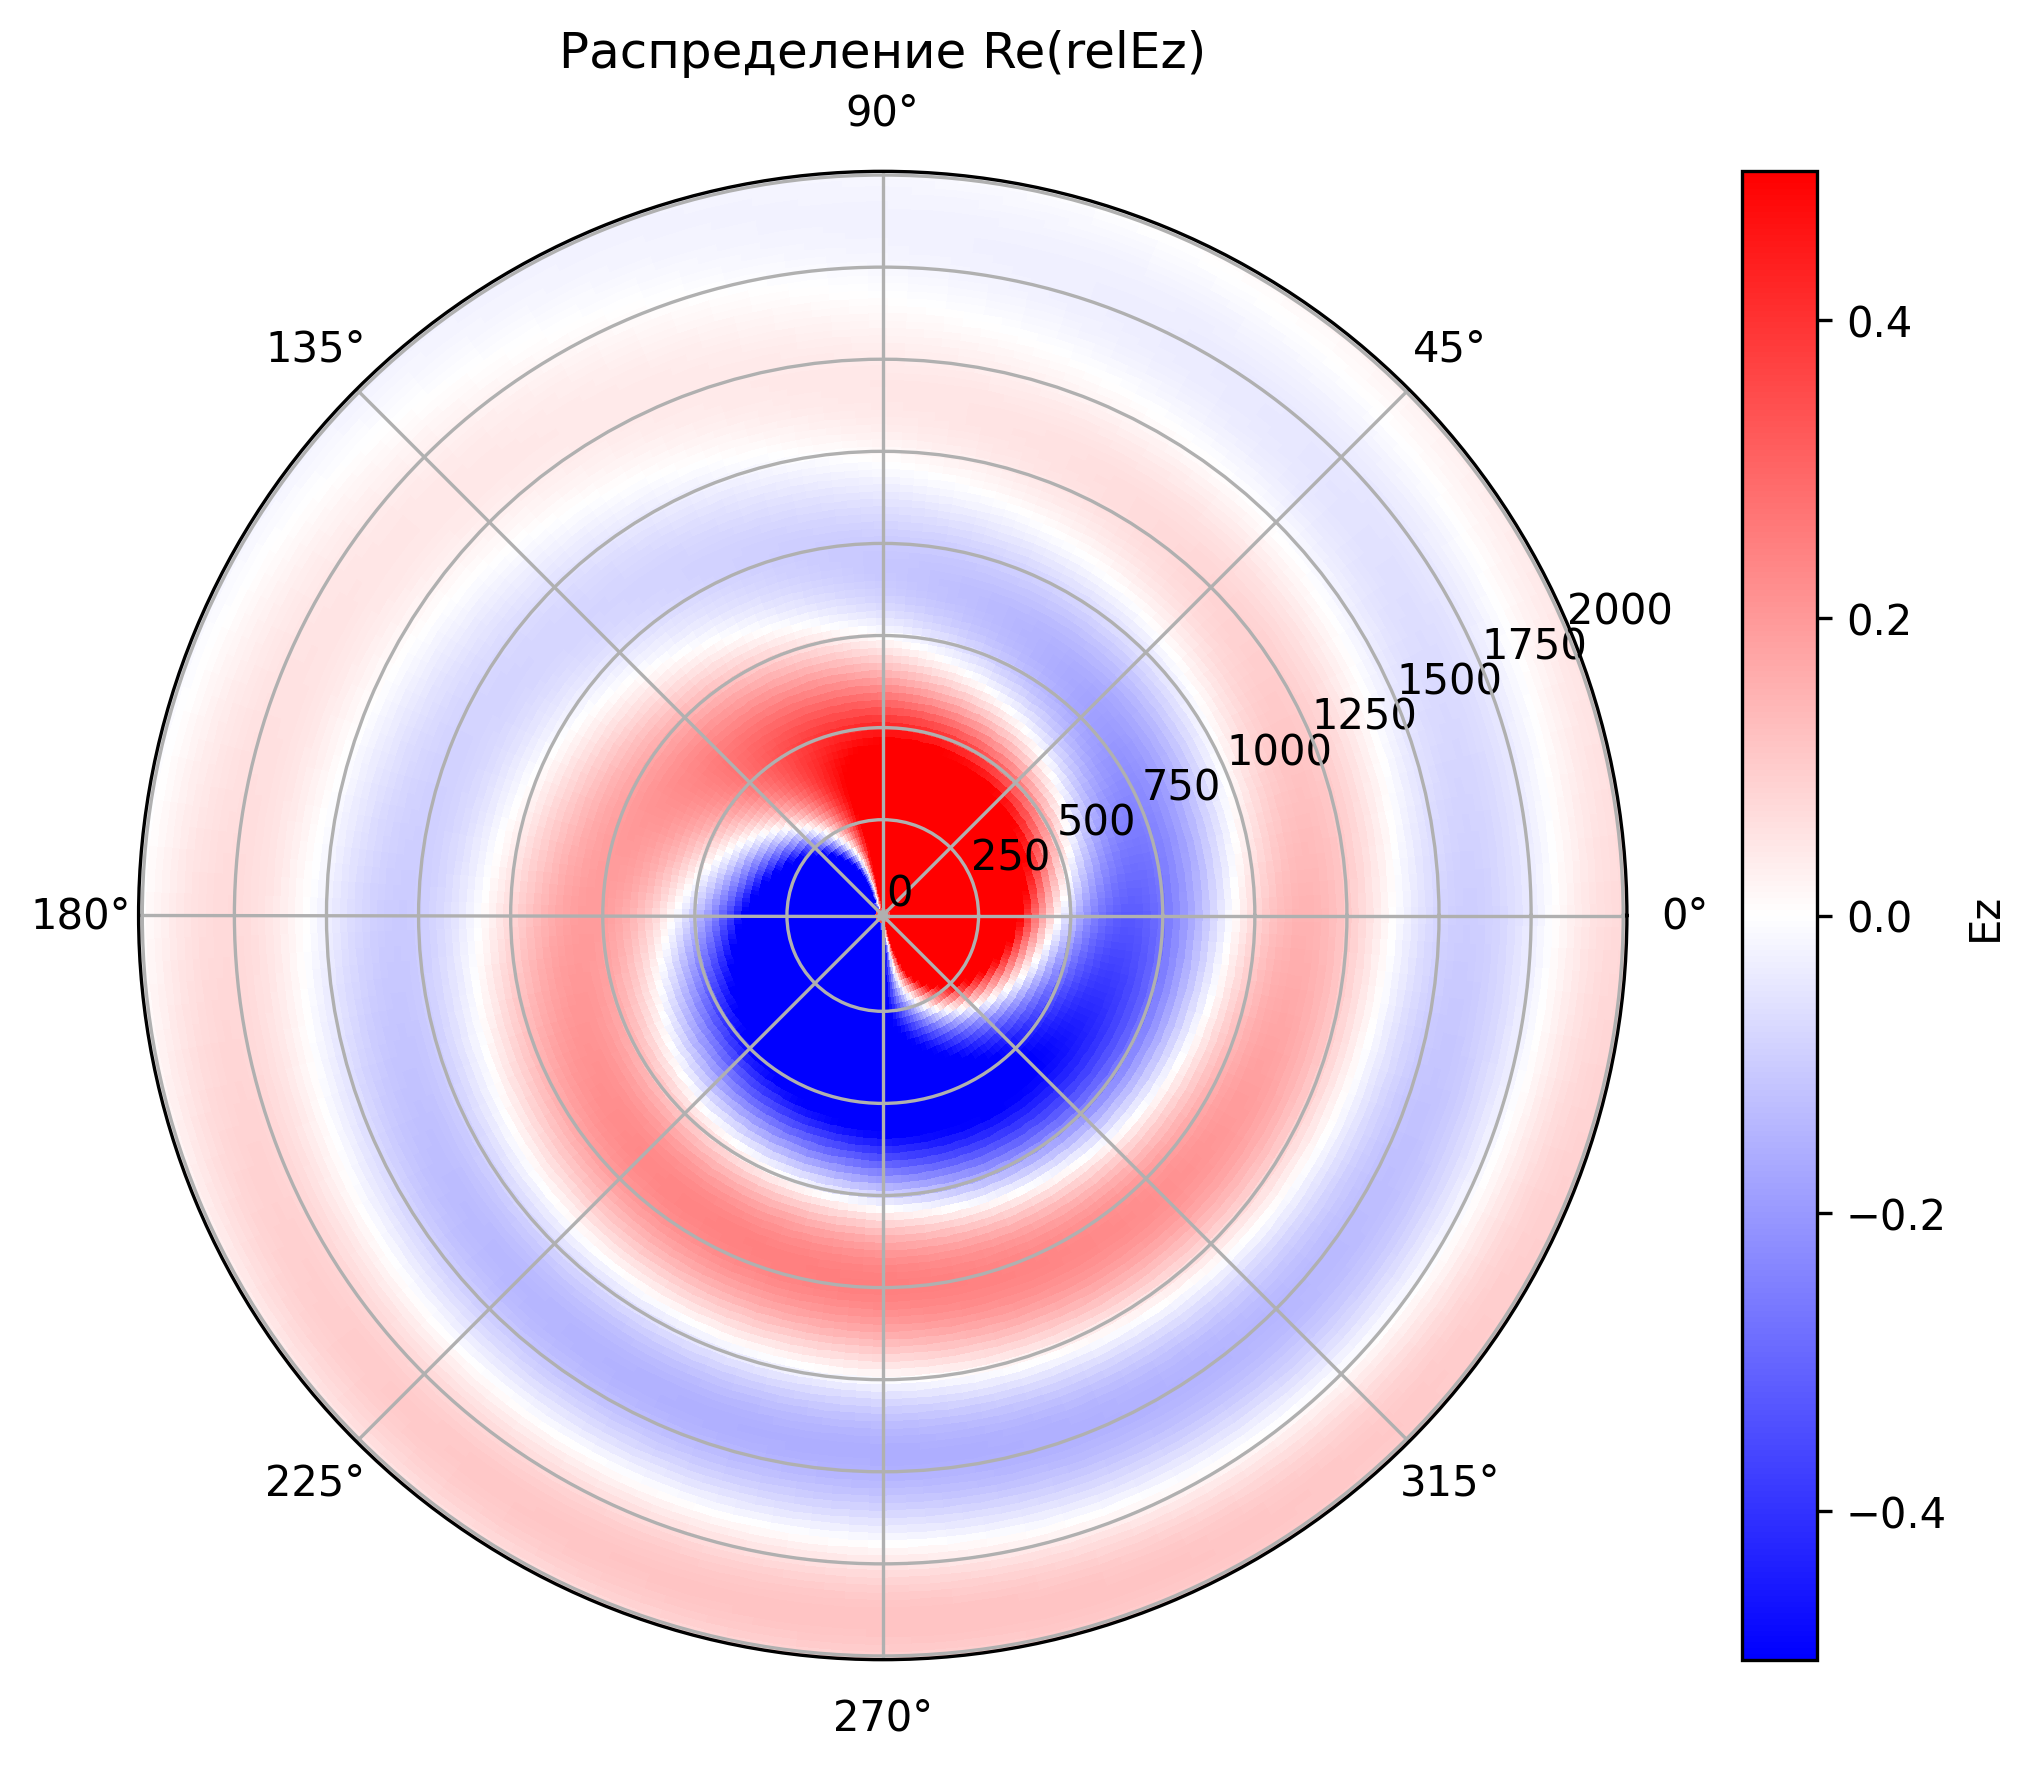

In [45]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Ez'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

exx = FiledFull.df['Ex'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

eyy = FiledFull.df['Ey'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

err = np.cos(phi_mesh) * exx + np.sin(phi_mesh) * eyy

epp = -np.sin(phi_mesh) * exx + np.cos(phi_mesh) * eyy

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6),dpi=300)

c = ax.pcolormesh(phi_mesh, r_mesh, -comp_vals.imag, shading='auto', cmap='bwr', vmax=0.5, vmin=-0.5)

fig.colorbar(c, ax=ax, label=f"{comp}")

# fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')

plt.tight_layout()

ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
# plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

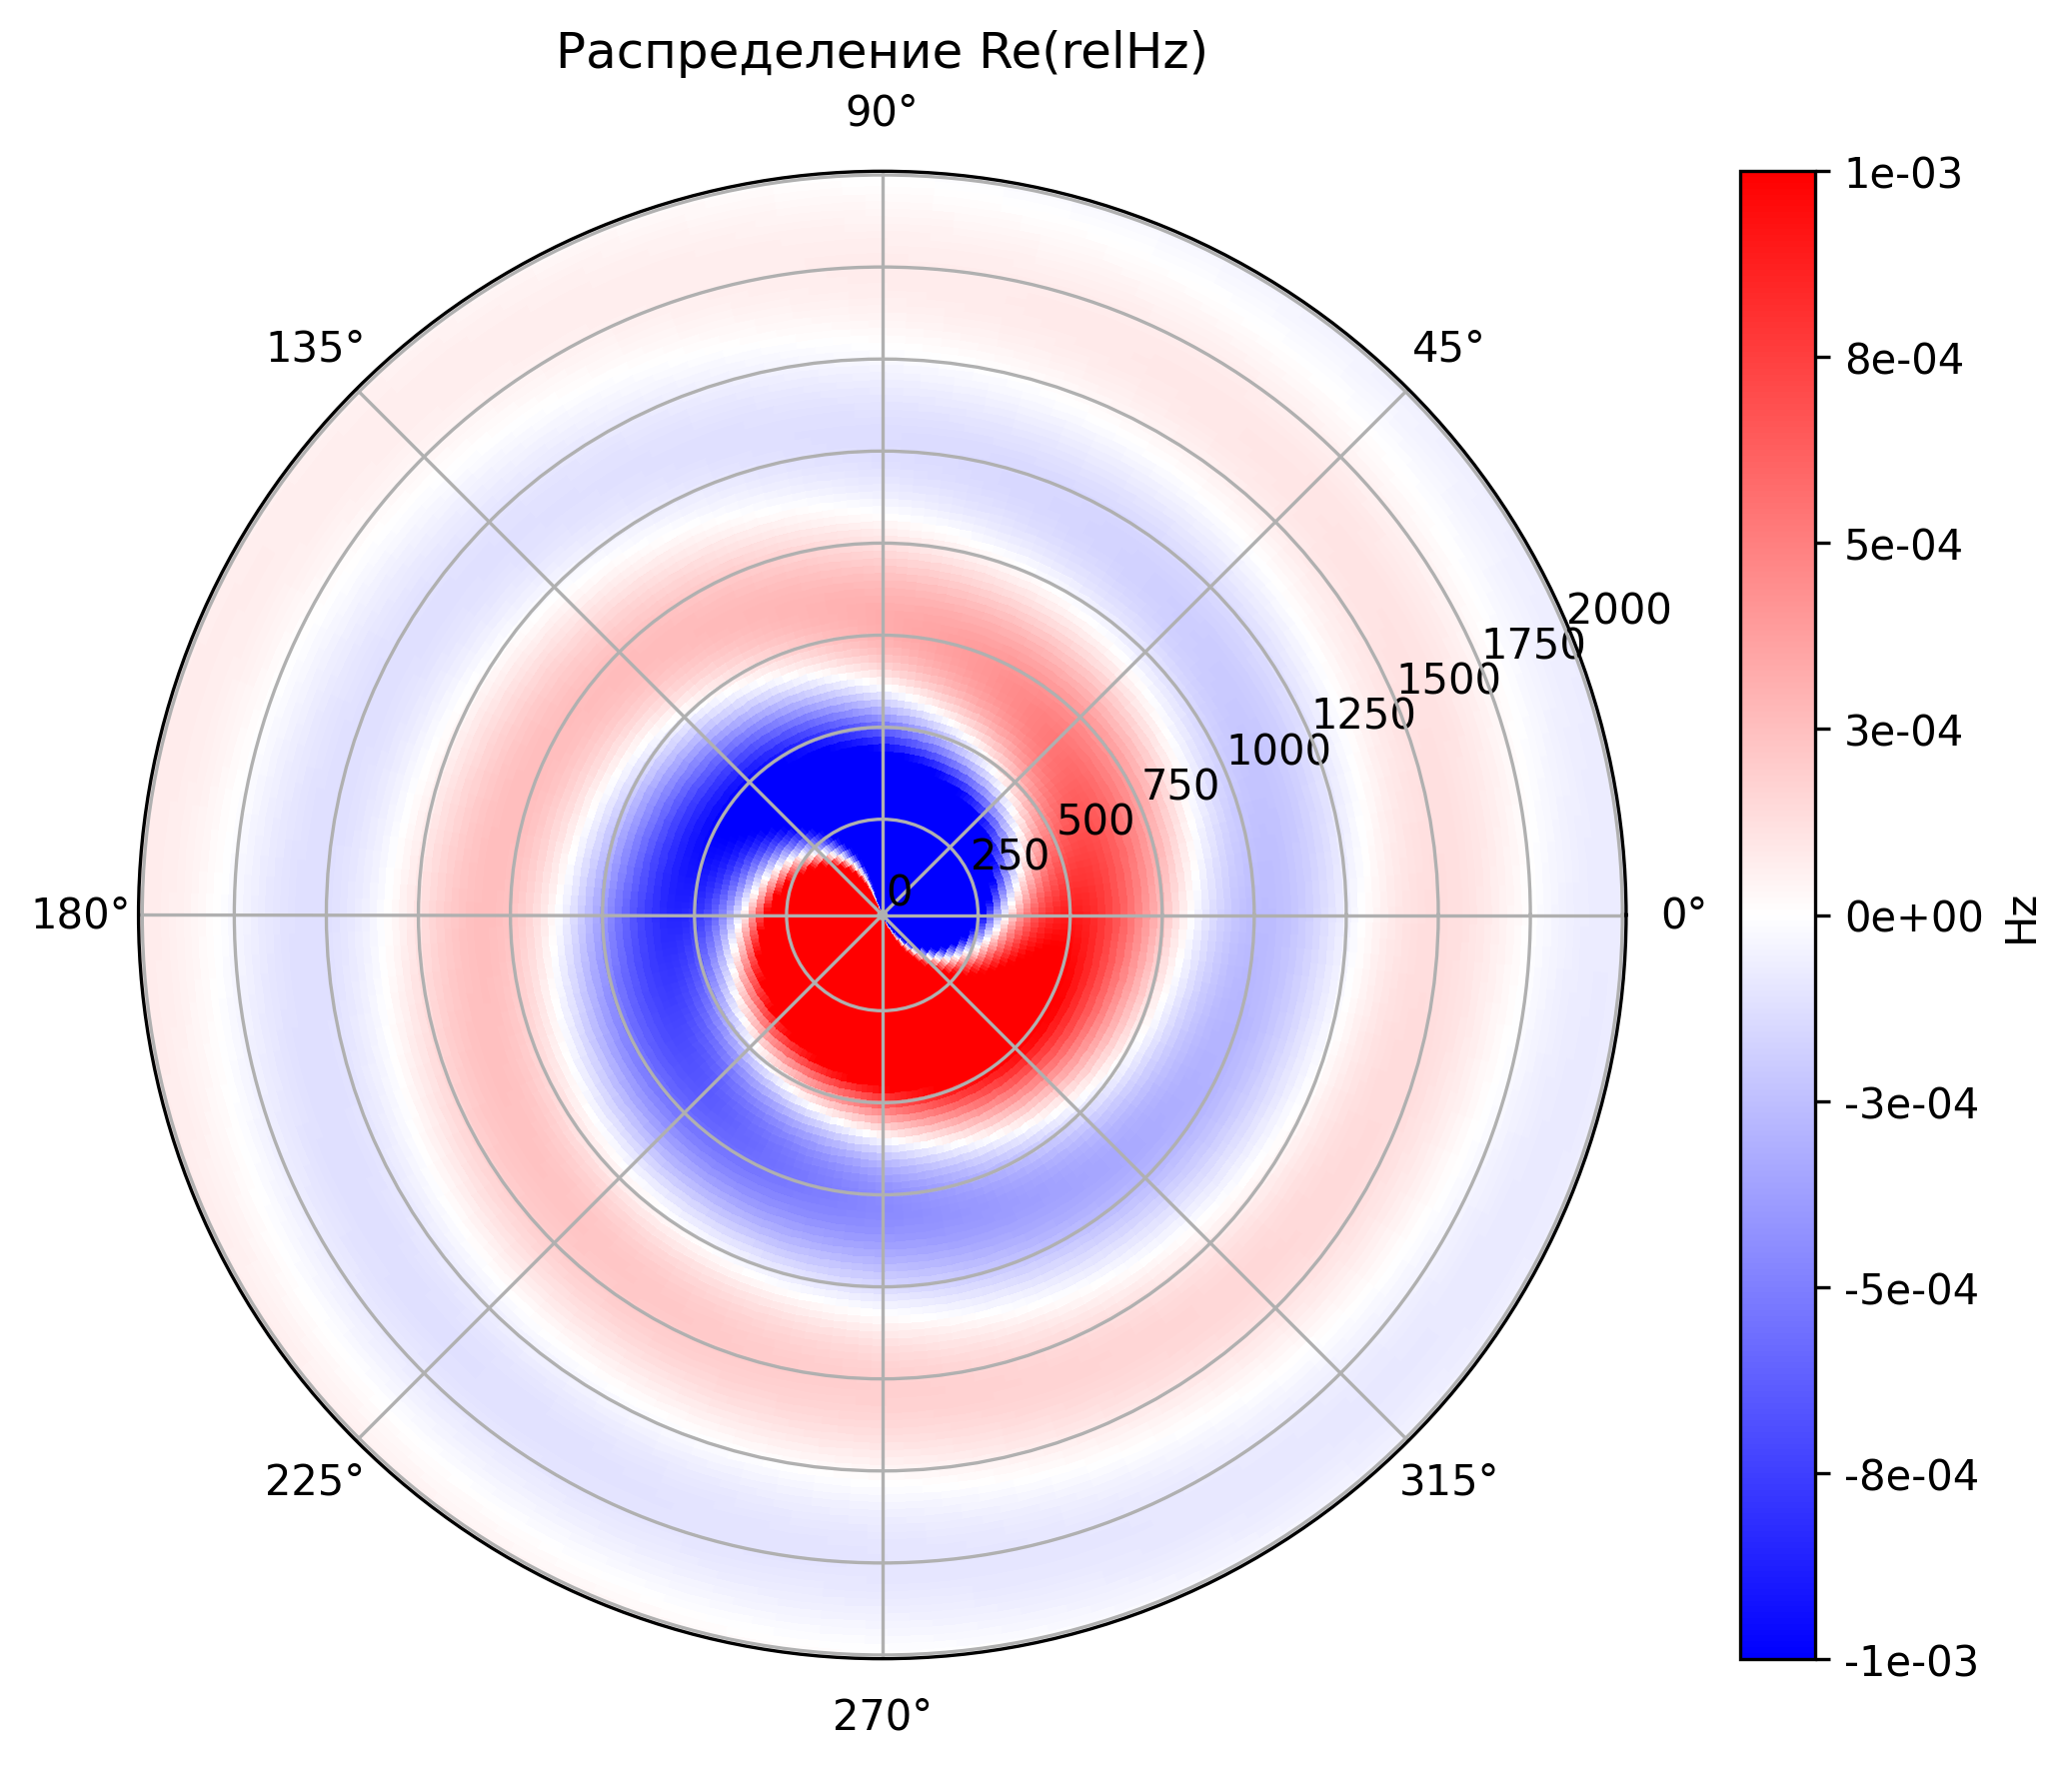

In [64]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Hz'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

hxx = FiledFull.df['Hx'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

hyy = FiledFull.df['Hy'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

hrr = np.cos(phi_mesh) * hxx + np.sin(phi_mesh) * hyy

hpp = -np.sin(phi_mesh) * hxx + np.cos(phi_mesh) * hyy

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6), dpi=300)

c = ax.pcolormesh(phi_mesh, r_mesh, -hrr.imag, shading='auto', cmap='bwr', vmax=1e-3, vmin=-1e-3)


fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')



ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
#plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

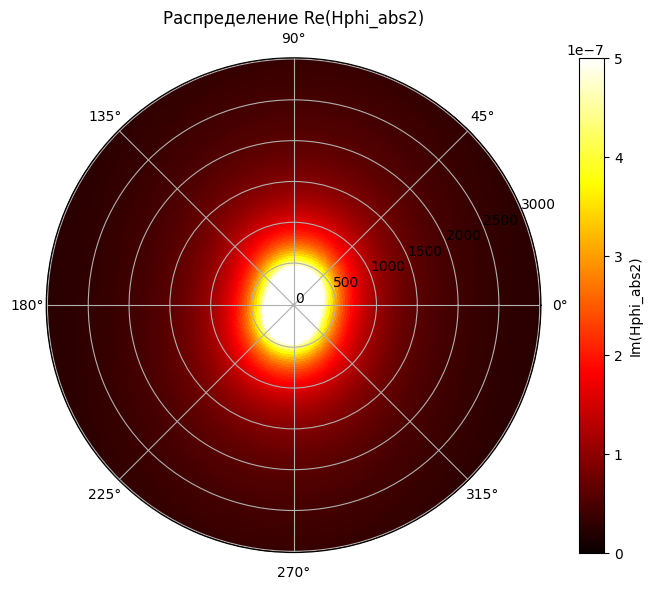

In [48]:
import matplotlib.pyplot as plt
import numpy as np

comp = 'Hphi_abs2'

r_vals = FiledSPP.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledSPP.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledSPP.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

# Построение сырых данных точками
sc = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.real, cmap='hot', vmin=0, vmax=0.5*1e-6)

fig.colorbar(sc, ax=ax, label=f"Im({comp})")

ax.set_title(f"Распределение Re({comp})")
plt.tight_layout()
plt.show()

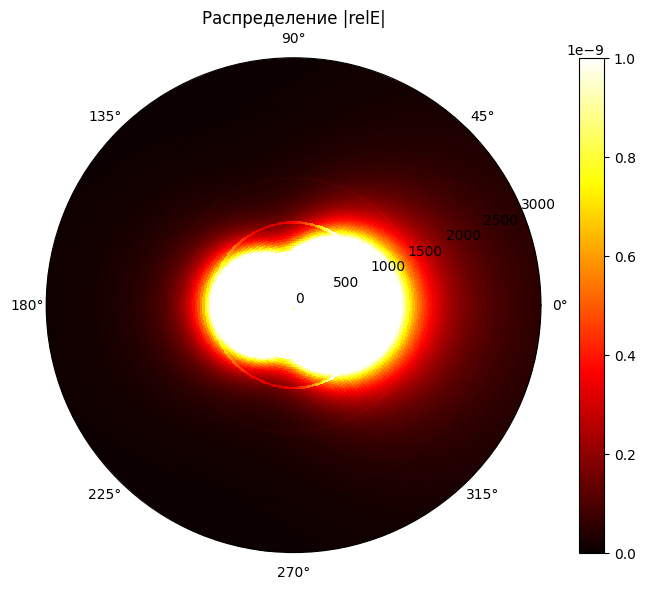

In [46]:
import matplotlib.pyplot as plt
import numpy as np


r_vals = FiledSPP.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledSPP.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

Ex = FiledSPP.df['Ex'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ey = FiledSPP.df['Ey'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ez = FiledSPP.df['Ez'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

Hx = FiledSPP.df['Hx'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hy = FiledSPP.df['Hy'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hz = FiledSPP.df['Hz'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

Sx = 0.5*np.real(Ey*np.conj(Hz) - Ez*np.conj(Hy))
Sy = 0.5*np.real(Ez*np.conj(Hx) - Ex*np.conj(Hz) )
Sz = 0.5* np.real(Ex*np.conj(Hy) - Ey*np.conj(Hz))

#c = ax.pcolormesh(phi_mesh, r_mesh, np.sqrt(Ex*Ex.conj()+Ey*Ey.conj()+Ez*Ez.conj()).real, shading=None, cmap='hot', vmax=0.5, vmin=0)

#c = ax.pcolormesh(phi_mesh, r_mesh, np.sqrt(Hx*Hx.conj()+Hy*Hy.conj()+Hz*Hz.conj()).real, shading=None, cmap='hot', vmin=0, vmax=1e-2*0.3)

c = ax.pcolormesh(phi_mesh, r_mesh, np.abs(Sx*np.cos(phi_mesh)+np.sin(phi_mesh)*Sy)**2, shading=None, cmap='hot',vmax=1e-9, vmin=0)


fig.colorbar(c, ax=ax)

ax.set_title(f"Распределение |relE|")
plt.tight_layout()
ax.grid()
plt.show()

In [ ]:
setattr(base_config, 'R', 10*ureg.nm)
Filed_Small = FieldsCalculator(base_config).compute(grid)
setattr(base_config, 'R', (295/2)*ureg.nm)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


r_vals = Filed.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = Filed.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

Ex_small = Filed_Small.df['Ex'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ey_small = Filed_Small.df['Ey'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Ez_small = Filed_Small.df['Ez'].apply(lambda x: x.to('V/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

Hx_small = Filed_Small.df['Hx'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hy_small = Filed_Small.df['Hy'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))
Hz_small = Filed_Small.df['Hz'].apply(lambda x: x.to('A/m').magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

normE_small = np.sqrt(Ex_small*Ex_small.conj() + Ey_small*Ey_small.conj() + Ez_small*Ez_small.conj())

c = ax.pcolormesh(phi_mesh, r_mesh, Ex_small.real, shading='auto', cmap='bwr')

fig.colorbar(c, ax=ax)

ax.set_title(f"Распределение Re(Ex)")
plt.tight_layout()
ax.grid()
plt.show()

In [ ]:
from MieSppForce import green_func, frenel


eps_Au = frenel.get_interpolate('Au')
wl = 900
z0 = 149.5
r = np.sqrt(1000**2 + 1000**2)
phi = np.pi/4
z=1000
STOP = 35

GE = green_func.getGE(wl, eps_Au, z0, r, phi, z,  STOP)